# Clustering et word2vec

Sur la base des éléments méthodologiques et des enseignements techniques présentés lors du cours théorique, il est demandé dans le cadre de ce TP :
- d’effectuer un clustering des bulletins pour une décennie au choix et d’interpréter les résultats
- d’entraîner un modèle word2vec sur l’ensemble des bulletins et d’explorer les relations entre vecteurs

Pour ce faire, vous utiliserez différentes librairies Python vues au cours comme scikit-learn et gensim.

#### Librairies nécessaires

In [1]:
import collections
import os
import string
import sys

import pandas as pd

import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

from pprint import pprint

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Clustering

#### Choisir une décénie et charger les fichiers

In [78]:
data_path = "../data/txt/"

In [249]:
DECADE = '1960'

In [250]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [251]:
# vérifier les fichiers
files[:5]

['Bxl_1960_Tome_II1_Part_1.txt',
 'Bxl_1960_Tome_II1_Part_2.txt',
 'Bxl_1960_Tome_II1_Part_3.txt',
 'Bxl_1960_Tome_II1_Part_4.txt',
 'Bxl_1960_Tome_II1_Part_5.txt']

In [252]:
texts = [open(data_path + f).read() for f in files]

In [253]:
# explorer un texte
texts[0][:400]

'PUBLICATION\n\nPERIODIQUE\n\nVILLE DE BRUXELLES\n\nAnnée 1960\n\nBULLETIN\nCOMMUNAL\nTOME II "\n_u\n\nImpr. H . 6 M . S C H A U M A N S\nSociété\n\nAnonyme\n\nParvis Saint-Gilles, 41\nBruxelles\n1960\n\n\x0c\x0cN" 14\n\nCOMPTE\n\nR E N D U D E L A S E A N C E D U 1"\' A O U T\n\nVILLE\n\nDE\n\n1960\n\nBRUXELLES\n\nBULLETIN\n\nCOMMUNAL\n\n(Publication\n\npériodique)\n\nA n n é e 1960\n\nCONSEIL\n\nS é a n c e du\n\nPRESIDENCE\n\nCOMMUNAL\n\n1\n\ner\n\naoût\n\nDE M'

#### Vectoriser les fichiers

In [254]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [255]:
# instancier le modèle
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [256]:
# construire la matrice
%time tfidf_vectors = vectorizer.fit_transform(texts)

CPU times: user 3min 12s, sys: 0 ns, total: 3min 12s
Wall time: 3min 12s


In [257]:
# vecteur du premier document
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

+considérant    0.300647
fer             0.228639
curage          0.207466
dma             0.153796
art             0.147675
                  ...   
engagé          0.000000
engager         0.000000
engagements     0.000000
engage          0.000000
™               0.000000
Length: 6466, dtype: float64

In [258]:
# transfert vers un tableau pour effectuer des tests
tfidf_array = tfidf_vectors.toarray()

#### Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

In [265]:
N_CLUSTERS = 6

#### Instancier le modèle K-Means et ses arguments

In [266]:
km_model = KMeans(n_clusters=N_CLUSTERS, random_state = 42)

#### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [267]:
clusters = km_model.fit_predict(tfidf_vectors)

In [268]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

#### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA

In [269]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

### Générer le plot

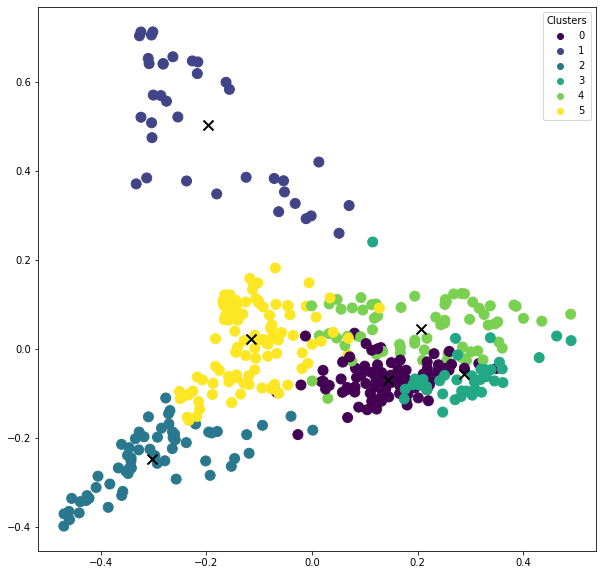

In [270]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

In [271]:
pprint(dict(clustering))

{0: ['Bxl_1962_Tome_II1_Part_3.txt',
     'Bxl_1963_Tome_II1_Part_6.txt',
     'Bxl_1963_Tome_II2_Part_8.txt',
     'Bxl_1964_Tome_II1_Part_4.txt',
     'Bxl_1964_Tome_II1_Part_6.txt',
     'Bxl_1965_Tome_II1_Part_1.txt',
     'Bxl_1965_Tome_II1_Part_7.txt',
     'Bxl_1965_Tome_II1_Part_9.txt',
     'Bxl_1965_Tome_II2_Part_10.txt',
     'Bxl_1965_Tome_II2_Part_11.txt',
     'Bxl_1965_Tome_II2_Part_12.txt',
     'Bxl_1965_Tome_II2_Part_9.txt',
     'Bxl_1965_Tome_I_Part_1.txt',
     'Bxl_1965_Tome_I_Part_12.txt',
     'Bxl_1965_Tome_I_Part_2.txt',
     'Bxl_1965_Tome_I_Part_3.txt',
     'Bxl_1965_Tome_I_Part_4.txt',
     'Bxl_1965_Tome_I_Part_6.txt',
     'Bxl_1966_Tome_I1_Part_1.txt',
     'Bxl_1966_Tome_I1_Part_10.txt',
     'Bxl_1966_Tome_I1_Part_4.txt',
     'Bxl_1966_Tome_I1_Part_5.txt',
     'Bxl_1966_Tome_I1_Part_6.txt',
     'Bxl_1966_Tome_I1_Part_7.txt',
     'Bxl_1966_Tome_I1_Part_9.txt',
     'Bxl_1966_Tome_I2_Part_4.txt',
     'Bxl_1966_Tome_I2_Part_6.txt',
     'Bxl_1966_To

Avec six clusters, plutôt que quatre, nous divisons plusieurs amas de manière plus claire. Il semble que le cluster [3] soit assez cohérent, étant donné qu'il apparaît déjà tel quel avec quatre clusters. En regardant le détail, nous pouvons remarquer que les années reprises concernent exclusivement les années 1968 et 1969. Peut-être que le thème de la révolution de 68 en est la cause?! Afin d'explorer plus finement ce cluster, je propose de sélectionner les fichiers de ce cluster et de procéder à la même opération pour identifier d'éventuels sous clusters à l'intérieur de celui-ci.

### Clustering d'un cluster

#### Exploration cluster [3]

In [152]:
files_3 = [f for f in sorted(os.listdir(data_path)) if f in clustering[3]]

for f in clustering[3]:
    texts_3 = [open(data_path + f).read() for f in files_3]
    
texts_3[5][3400:5000]

".\n(2) Zie blz. 195 de namen van de leden die aan de stemming hebben\ndeelgenomen.\n\n\x0c— 201 —\n\n(3 februari 1969)\n\nCommission d'Assistance publique.\nActes divers d'administration.\nM . l'Echevin Van Halteren fait, au nom du Collège, les\nrapports suivants :\nDe heer Schepen Van Halteren brengt, namens het Collège de volgende verslagen uit :\nHôpital Saint-Pierre. — Service d'obstétrique-gynécologie.\n(N* HP. 51/68/3 — 70/68 — 0.1. n° 45.)\nPrincipe d'une dépense de 276.000 francs pour l'installation\nd'une signalisation lumineuse et d'une interphonie.\nPar délibération en date du 5 novembre 1968, la Commission d'Assistance publique sollicite du Pouvoir compétent l'autorisation de faire la dépense mentionnée sous rubrique.\nJustification de la proposition :\nAfin de mettre fin aux inconvénients provoqués par l'usure\nde l'installation de signalisation par sonneries d'appel dans\ncertaines salles du service d'obstétrique-gynécologie de l'Hôpital Saint-Pierre, il y a lieu de remp

In [153]:
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

vectorizer_3 = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

tfidf_vectors_3 = vectorizer_3.fit_transform(texts_3)

pd.Series(
    tfidf_vectors_3[0].toarray()[0],
    index=vectorizer_3.get_feature_names_out()
    ).sort_values(ascending=False)

transferts     0.190398
facturation    0.163975
saldo          0.147166
definitief     0.124706
plannen        0.124682
                 ...   
e++v           0.000000
e++u           0.000000
e++se          0.000000
e++r           0.000000
•'+présents    0.000000
Length: 9637, dtype: float64

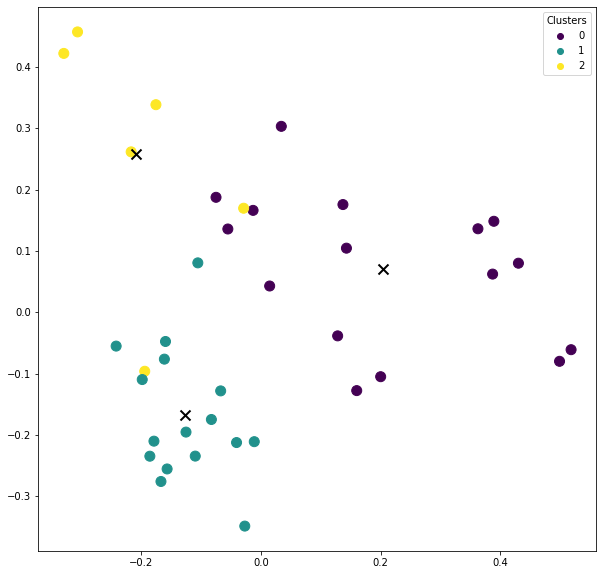

In [161]:
N_CLUSTERS = 3

#instancier le modèle KMeans
km_model = KMeans(n_clusters=N_CLUSTERS, random_state = 42)

# appliquer le clustering
clusters_3 = km_model.fit_predict(tfidf_vectors_3)

clustering_3 = collections.defaultdict(list)

for idx, label in enumerate(clusters_3):
    clustering_3[label].append(files_3[idx])

# réduire les dimensions
pca = PCA(n_components=2)
reduced_vectors_3 = pca.fit_transform(tfidf_vectors_3.toarray())

# générer le plot
x_axis = reduced_vectors_3[:, 0]
y_axis = reduced_vectors_3[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters_3)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters_3), title="Clusters")

In [162]:
pprint(dict(clustering_3))

{0: ['Bxl_1968_Tome_II1_Part_2.txt',
     'Bxl_1968_Tome_II1_Part_3.txt',
     'Bxl_1968_Tome_II1_Part_4.txt',
     'Bxl_1969_Tome_I1_Part_5.txt',
     'Bxl_1969_Tome_II1_Part_6.txt',
     'Bxl_1969_Tome_II1_Part_7.txt',
     'Bxl_1969_Tome_II1_Part_8.txt',
     'Bxl_1969_Tome_II2_Part_1.txt',
     'Bxl_1969_Tome_II2_Part_10.txt',
     'Bxl_1969_Tome_II2_Part_2.txt',
     'Bxl_1969_Tome_II2_Part_3.txt',
     'Bxl_1969_Tome_II2_Part_4.txt',
     'Bxl_1969_Tome_II2_Part_5.txt',
     'Bxl_1969_Tome_II2_Part_6.txt',
     'Bxl_1969_Tome_II2_Part_7.txt',
     'Bxl_1969_Tome_II2_Part_9.txt'],
 1: ['Bxl_1969_Tome_I1_Part_1.txt',
     'Bxl_1969_Tome_I1_Part_2.txt',
     'Bxl_1969_Tome_I1_Part_3.txt',
     'Bxl_1969_Tome_I1_Part_6.txt',
     'Bxl_1969_Tome_I1_Part_7.txt',
     'Bxl_1969_Tome_I1_Part_8.txt',
     'Bxl_1969_Tome_I2_Part_1.txt',
     'Bxl_1969_Tome_I2_Part_2.txt',
     'Bxl_1969_Tome_I2_Part_4.txt',
     'Bxl_1969_Tome_I2_Part_5.txt',
     'Bxl_1969_Tome_I2_Part_6.txt',
     'Bxl_1

#### Exploration cluster [0] du cluster [3]

In [219]:
files_3_0 = [f for f in sorted(os.listdir(data_path)) if f in clustering_3[0]]

for f in clustering_3[0]:
    texts_3_0 = [open(data_path + f).read() for f in files_3_0]
    
texts_3_0[2][5000:7000]

"Universiteit te Brussel op 3, 4\nen 5 december 1968.\n— M . le Bourgemestre ouvre la séance et fait une déclaration\nrelative aux incidents qui se sont produits à l'Université\nlibre de Bruxelles les 3, 4 et 5 d é c e m b r e 1968.\n\nM . V a n Geyt. Je tiens d'abord à vous remercier pour l'information que vous avez bien voulu donner par courtoisie. E n\ndeuxième lieu, je tiens à vous donner acte du fait que d'après\ntous les renseignements que vous avez c o m m u n i q u é s , les\ndiverses interventions policières ont eu lieu à l'initiative des\nautorités de l'Université et que, par conséquent, le p r o b l è m e\nde la justification ou non de l'appel à ces interventions est du\nressort de l'Université et des divers milieux qui la composent.\nJe me permettrai toutefois de faire une seule remarque à\npropos de ces incidents extrêmement regrettables ; en effet.\n\n\x0c— 1517 —\n\n(9 décembre\n\n1968)\n\ndans les rapports dont vous avez d o n n é lecture, les autorités\nauxquelles vous

In [220]:
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

vectorizer_3_0 = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

tfidf_vectors_3_0 = vectorizer_3_0.fit_transform(texts_3_0)

pd.Series(
    tfidf_vectors_3_0[0].toarray()[0],
    index=vectorizer_3_0.get_feature_names_out()
    ).sort_values(ascending=False)

décembre++1968      0.431605
.+majoration        0.188233
enseignement        0.161879
december++1968      0.157904
facturation         0.131739
                      ...   
démission           0.000000
démocratie          0.000000
démocratique        0.000000
démocratiquement    0.000000
•                   0.000000
Length: 11053, dtype: float64

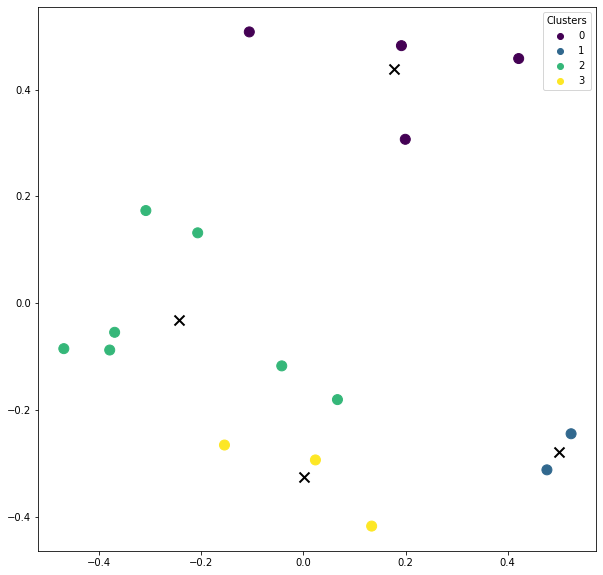

In [233]:
N_CLUSTERS = 4

#instancier le modèle KMeans
km_model = KMeans(n_clusters=N_CLUSTERS, random_state = 42)

# appliquer le clustering
clusters_3_0 = km_model.fit_predict(tfidf_vectors_3_0)

clustering_3_0 = collections.defaultdict(list)

for idx, label in enumerate(clusters_3_0):
    clustering_3_0[label].append(files_3_0[idx])

# réduire les dimensions
pca = PCA(n_components=2)
reduced_vectors_3_0 = pca.fit_transform(tfidf_vectors_3_0.toarray())

# générer le plot
x_axis = reduced_vectors_3_0[:, 0]
y_axis = reduced_vectors_3_0[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters_3_0)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters_3_0), title="Clusters")

In [234]:
pprint(dict(clustering_3_0))

{0: ['Bxl_1968_Tome_II1_Part_2.txt',
     'Bxl_1968_Tome_II1_Part_3.txt',
     'Bxl_1968_Tome_II1_Part_4.txt',
     'Bxl_1969_Tome_II2_Part_1.txt'],
 1: ['Bxl_1969_Tome_II2_Part_2.txt', 'Bxl_1969_Tome_II2_Part_3.txt'],
 2: ['Bxl_1969_Tome_I1_Part_5.txt',
     'Bxl_1969_Tome_II1_Part_6.txt',
     'Bxl_1969_Tome_II1_Part_7.txt',
     'Bxl_1969_Tome_II1_Part_8.txt',
     'Bxl_1969_Tome_II2_Part_6.txt',
     'Bxl_1969_Tome_II2_Part_7.txt',
     'Bxl_1969_Tome_II2_Part_9.txt'],
 3: ['Bxl_1969_Tome_II2_Part_10.txt',
     'Bxl_1969_Tome_II2_Part_4.txt',
     'Bxl_1969_Tome_II2_Part_5.txt']}


Il est difficile de juger de la pertinence des clusters sur un si grand nombre de fichiers, si ce n'est en se fiant au score 'cosine'. 

Cependant, cette technique de clustering représente un intérêt pour classer les fichiers entre eux afin d'explorer des "thématiques" communes sur base de la fréquence des mots de l'ensemble étudié. En rassemblant les fichiers et les traitant à l'aide de fonctions de nettoyage plus poussées, il sera sans doute plus facile d'éliminer des mots fréquents de l'ensemble des "paquets" afin d'explorer plus finement le contenu. Des listes de stopwords peuvent être consitutées en fonction des clusters et ainsi permettre de faire ressortir du contenu plus informationnel.

Pour vérifier la méthode, il faudrait pouvoir explorer les contenus de manière plus aisée, en procédant par exemple à des wordclouds ou en extrayant les keywords pour chacun des clusters. Je n'ai malheureusement pas eu le temps d'approfondir la question.

## 2. Word2Vec

Avant de procéder à l'amélioration du modèle en appliquant successivement les fonctions bigrammes/trigrammes/quadrigrammes/pentagrammes, j'ai d'abord porcédé à l'exploration de différents caractéristiques déterminant la qualité des modèles. Le tableau ci-dessous reprend les résultats obtenus pour les mêmes requêtes. Celles-ci sont calquées sur celles présentées au cours.

Le modèle 1 est celui fourni à la base et appliqué à une partie du corpus (fichier 'sents' créé à l'aide du notebook du cours). Tous les autres modèles se basent sur le fichier de Max De Wilde, renommé en 'sents_2'. J'ai ensuite fait varier la taille du vecteur (32, 100 ou 300), la taille de la fenêtre (5, 7, 10, 13, 20, 40), la fréquence minimale des mots, le nombre de 'workers' et les 'epochs'. Ceci m'a permis d'approcher les différences en fonction de requêtes similaires appliquées à l'ensemble des modèles. 

Mes principales constations sont que le nombre d''epochs' semble améliorer les performances des modèles quelque soit la taille du vecteur. Le nombre de 'workers' semble diminuer la précision des modèles. La taille du vecteur et de la fenêtre augmentent la sensibilité des modèles ; ils semblent devenir plus "sensibles", plus "subtiles" mais peut-être moins "précis". Ainsi, avec une vecteur de 100 et une fenêtre de 7, le modèle parvient à comprendre que le charcutier est au plus proche du boucher, que les autres métiers généralement renseignés. Remarquons qu'avec un vecteur de 300, il faut élargir la taille du vecteur à 13 pour parvenir à un tel résultat.

J'opte donc a priori pour des modèles dont la taille de la fenêtre augmente en fonction de la taille du vecteur. Cependant, il faudra voir si l'application plus poussée des fonctions du Phraser ne viendra pas perturber ces résultats. Quant à la fréquence des mots, je décide de l'abaisser à deux, jugeant qu'il est nécessaire pour Word2vec d'avoir un maximum d'information pour l'analyse ; les mots présents une seule fois, autrement dit les hapax.

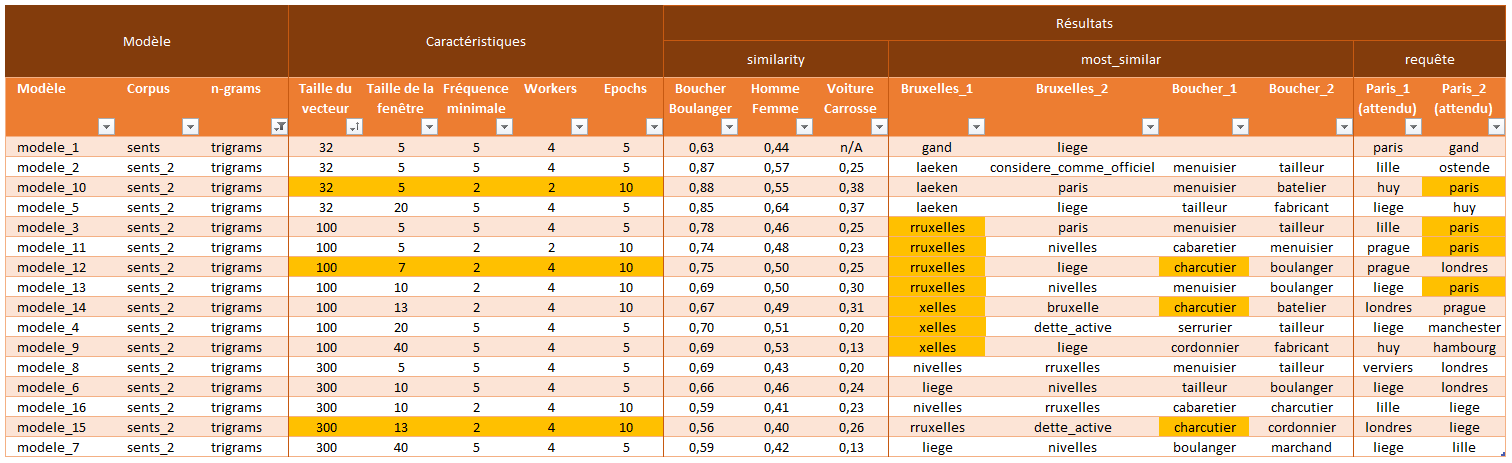

Tous les résultats sont disponibles dans le repo du module 4, dans les deux forks du notebook pour le word embeddings.

#### Chargement des phrases

In [2]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [3]:
infile = f"../data/sents_2.txt"

In [4]:
sentences = MySentences(infile)

#### Création des bigrammes

In [5]:
bigram_phrases = Phrases(sentences)

In [6]:
len(bigram_phrases.vocab.keys())

5978799

In [7]:
%time bigram_phrases[sentences]

CPU times: user 3.2 ms, sys: 21 µs, total: 3.22 ms
Wall time: 3.89 ms


In [8]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

In [9]:
%time bigram_phraser[sentences]

CPU times: user 0 ns, sys: 4.69 ms, total: 4.69 ms
Wall time: 3.44 ms


In [10]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [11]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

In [12]:
quadrigram_phrases = Phrases(trigram_phraser[sentences])

In [13]:
quadrigram_phraser = Phraser(phrases_model=quadrigram_phrases)

In [14]:
pentagram_phrases = Phrases(quadrigram_phraser[sentences])

In [15]:
pentagram_phraser = Phraser(phrases_model=pentagram_phrases)

In [16]:
corpus = list(pentagram_phraser[quadrigram_phraser[trigram_phraser[bigram_phraser[sentences]]]])

In [17]:
print(corpus[:10])

[['v', 'i', 'l', 'l', 'e', 'de', 'bruxelles', 'bulletin', 'ires', '8eanas', 'dl', '!'], ['conseil_communal', 'annee', '1847', '.'], ['au', 'ville', 'de', 'b', 'r', 'u', 'x', 'e', 'l', 'l', 'e', 's', '.'], ['bulletin', 'conseil', 'aes', 'seances', 'communal', '.'], ['annee', '1847', '.'], ['bruxelles', ',', 'imprimerie', 'd', 'e', 'j', '.'], ['h', '.', 'b', 'r', 'i', 'a', 'r', 'd', ',', 'rite', 'n', 'e', 'u', 'v', 'e', ',', '3', '1', ',', 'faubourg', 'de', 'n', 'a', 'm', 'u', 'r', ',', '1', '84', '8', 'de', '!'], ['du', 'consei', 'dibi', 'e', '.', '-', 'communication', 'conclusions', 'de', 'la', 'section', 'des', 'du', 'nouvel_hospice', 'pour', 'les', 'av', 'enraisonde', 'l', "'", 'absence', '&', 'maladie', '.', 'le', 'conseil', 'ajourne', 'leurs', 'de', 'pierre', 'el', 'marchai', 'cles', 'des', 'taxes', 'communale', "'", 'bieniaance', 'eldeseianv', 'il', 'est', 'donne', 'communie', ';', 'mandant', 'le', 'o', 'p', 'fa', 'gnant', 'l', "'", 'envoi', 'de', 'leur', 'bn', 'par', 'l', "'", 'e

#### Modèle 1 du tp3 (300-10)

In [ ]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=300, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=10, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

In [ ]:
outfile = f"../data/bulletins_tp3_1_bis.model"
model.save(outfile)

In [ ]:
model = Word2Vec.load("../data/bulletins_tp3_1_bis.model")

#### Exploration du modèle

In [ ]:
model.wv.similarity("boucher", "boulanger")

In [ ]:
model.wv.similarity("homme", "femme")

In [ ]:
model.wv.similarity("voiture", "carrosse")

In [ ]:
model.wv.similarity("voiture", "chien")

In [ ]:
model.wv.most_similar("bruxelles", topn=10)

In [ ]:
model.wv.most_similar("boucher", topn=10)

In [ ]:
model.wv.most_similar("platonisme", topn=10)

In [28]:
model.wv.most_similar("immigration", topn=100)

[('emigration', 0.6132327914237976),
 ('action_sociale', 0.5998521447181702),
 ('institution', 0.5998291969299316),
 ('homeopathie', 0.583960771560669),
 ('organisation', 0.5773417353630066),
 ('desorganisation', 0.5746116638183594),
 ('exigence', 0.5695797801017761),
 ('activite', 0.569557249546051),
 ('innovation', 0.5687636137008667),
 ('infortune', 0.5672561526298523),
 ('agitation', 0.5671695470809937),
 ('immoralite', 0.5640730261802673),
 ('organisation_administrative', 0.5599516034126282),
 ('aneantissement', 0.559761106967926),
 ('activite_economique', 0.555054247379303),
 ('integration', 0.5545611381530762),
 ('immunite', 0.5518489480018616),
 ('activite_industrielle', 0.5435838103294373),
 ('enseignement_public', 0.5416442155838013),
 ('expansion', 0.5400932431221008),
 ('instruction_obligatoire', 0.5396178364753723),
 ('instauration', 0.5390921831130981),
 ('administration_municipale', 0.5387990474700928),
 ('enseignement_populaire', 0.5381671190261841),
 ('infirmite', 0.53

In [ ]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

In [ ]:
print(model.wv.most_similar(positive=['bruxelles', 'espagne'], negative=['belgique']))

In [ ]:
print(model.wv.most_similar(positive=['bruxelles', 'allemagne'], negative=['belgique']))

In [ ]:
print(model.wv.most_similar(positive=['bruxelles', 'italie'], negative=['belgique']))

In [ ]:
print(model.wv.most_similar(positive=['bruxelles', 'russie'], negative=['belgique']))

In [ ]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme']))

In [ ]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

In [ ]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

In [ ]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

In [ ]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

In [ ]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

#### Modèle 2 du tp3 (32-10)

In [22]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=10, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 40min 4s, sys: 1min 51s, total: 41min 56s
Wall time: 14min 27s


In [23]:
# outfile = f"../data/bulletins_tp3_2.model"
# model.save(outfile)

In [79]:
model = Word2Vec.load("../data/bulletins_tp3_2.model")

In [25]:
model.wv.similarity("boucher", "boulanger")

0.8609588

In [26]:
model.wv.similarity("homme", "femme")

0.62290215

In [27]:
model.wv.similarity("voiture", "carrosse")

0.41236758

In [28]:
model.wv.similarity("voiture", "chien")

0.5687413

In [ ]:
model.wv.most_similar("migration", topn=100)

[('ribliotheques', 0.8022373914718628),
 ('eiude', 0.7945442795753479),
 ('0il', 0.7895975112915039),
 ('04i', 0.7873168587684631),
 ('transporls', 0.7859434485435486),
 ('schulbuchern', 0.7848593592643738),
 ('medications', 0.7806968092918396),
 ('tegrand', 0.7803698182106018),
 ('rarefaction', 0.7773084044456482),
 ('springacl', 0.7770878076553345),
 ('112112a', 0.7768541574478149),
 ('entas', 0.7700965404510498),
 ('abriteront', 0.7679513096809387),
 ('liberale_protestantse', 0.765661895275116),
 ('ioire', 0.7648190855979919),
 ('manceuvers', 0.7638876438140869),
 ('maladieschroniques', 0.7638323307037354),
 ('embargo', 0.7637114524841309),
 ('begrotingontwerp', 0.7636397480964661),
 ('tenanl', 0.7626122236251831),
 ('essuyant', 0.7625626921653748),
 ('8ps65', 0.7625022530555725),
 ('kaasmakers', 0.7624107599258423),
 ('biliaires', 0.762252688407898),
 ('infectants', 0.7610763907432556),
 ('primeveres_(_ch_.).', 0.760374903678894),
 ('marcotage', 0.7598103284835815),
 ('9801', 0.759

In [30]:
model.wv.most_similar("boucher", topn=10)

[('batelier', 0.8890909552574158),
 ('charcutier', 0.8885161876678467),
 ('macon', 0.8633956909179688),
 ('boulanger', 0.8609588742256165),
 ('menuisier', 0.8580062389373779),
 ('marchand', 0.8434250950813293),
 ('terrassier', 0.8390104174613953),
 ('cabaretier', 0.8362985253334045),
 ('tailleur', 0.8337821960449219),
 ('poissonnier', 0.8302710652351379)]

In [31]:
model.wv.most_similar("platonisme", topn=10)

[('beveiligen', 0.9539734721183777),
 ('kundig', 0.9495147466659546),
 ('lnventaris', 0.949018120765686),
 ('onze_maatschappij', 0.9476034045219421),
 ('haare', 0.9474144577980042),
 ('jser', 0.9442475438117981),
 ('haupt', 0.9437791109085083),
 ('ontduiking', 0.941407322883606),
 ('***>', 0.9412257075309753),
 ('efdael', 0.9409153461456299)]

In [32]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('huy', 0.8370460271835327), ('ostende', 0.8271083235740662), ('verviers', 0.8080962300300598), ('gand', 0.8075035810470581), ('liege', 0.8056627511978149), ('lille', 0.7857369184494019), ('paris', 0.7746098637580872), ('louvain', 0.7729559540748596), ('flandres', 0.7717507481575012), ('alost', 0.7653114199638367)]


In [61]:
print(model.wv.most_similar(positive=['bruxelles', 'espagne'], negative=['belgique']))

[('huy', 0.7904998660087585), ('ostende', 0.7780255079269409), ('alost', 0.7758798599243164), ('anvers', 0.7468335032463074), ('binche', 0.7457169890403748), ('tervueren', 0.7373207807540894), ('verviers', 0.7345232367515564), ('tournai', 0.7318522334098816), ('louvain', 0.7309636473655701), ('diest', 0.7263793349266052)]


In [62]:
print(model.wv.most_similar(positive=['bruxelles', 'allemagne'], negative=['belgique']))

[('ostende', 0.8068431615829468), ('anvers', 0.7899765372276306), ('flandres', 0.7598356008529663), ('huy', 0.7520290613174438), ('liege', 0.739467442035675), ('gand', 0.7379448413848877), ('alost', 0.7348196506500244), ('aux_confins', 0.7319079637527466), ('tervueren', 0.7246596813201904), ('verviers', 0.723300039768219)]


In [63]:
print(model.wv.most_similar(positive=['bruxelles', 'italie'], negative=['belgique']))

[('ostende', 0.8659056425094604), ('huy', 0.8336936831474304), ('alost', 0.8149629235267639), ('verviers', 0.8075150847434998), ('anvers', 0.8009089231491089), ('lille', 0.7917305827140808), ('amsterdam', 0.7838503122329712), ('tournai', 0.7779895663261414), ('binche', 0.7683148384094238), ('prague', 0.7661488056182861)]


In [64]:
print(model.wv.most_similar(positive=['bruxelles', 'russie'], negative=['belgique']))

[('ostende', 0.8164035677909851), ('koekelberg', 0.7838951945304871), ('carnieres', 0.7828735113143921), ('alost', 0.7827448844909668), ('huy', 0.7820681929588318), ('aux_confins', 0.7762884497642517), ('forest', 0.7740846276283264), ('tervueren', 0.7708583474159241), ('dtxelles', 0.7708445191383362), ('binche', 0.7688791155815125)]


In [33]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme']))

[('sieur_van_eesbeeck', 0.6661351323127747), ('messe_quotidienne', 0.6570274829864502), ('annep', 0.6544880867004395), ('brabant', 0.6392697095870972), ('dansante_sera', 0.6349672675132751), ('letttre', 0.6327504515647888), ('messe_solennelle', 0.6322498321533203), ('septembre_1949', 0.6276273131370544), ('congregation', 0.6272263526916504), ('unifamiliale', 0.6266288161277771)]


In [34]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('<<_je_jure', 0.8076946139335632), ('serment_suivant', 0.7857425808906555), ('cartel', 0.7674791812896729), ('verbe', 0.754385232925415), ('respect', 0.7543176412582397), ('mepris', 0.7468379139900208), ('je_jure_fidelite', 0.7452432513237), ('obeissance', 0.7366427183151245), ('peuple_belge', 0.7356619238853455), ('communisme', 0.7327820658683777)]


In [35]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('famille_royale', 0.739972710609436), ('suspension_entraine', 0.7090593576431274), ('commission_paritaire', 0.701867401599884), ('liberte_individuelle', 0.6872615814208984), ('reponse_donnee', 0.6771332025527954), ('liste_portait', 0.6767422556877136), ('elle_commettrait', 0.6667153835296631), ('prefecture', 0.6665677428245544), ('circonscription_militaire', 0.6577958464622498), ('libre_concurrence', 0.6552494168281555)]


In [ ]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('mansarde', 0.8571958541870117), ('cave', 0.8542822003364563), ('terrasse', 0.8352386355400085), ('glaciere', 0.8255090117454529), ('baignoire', 0.8180697560310364), ('chaudiere', 0.8113610148429871), ('cloison', 0.8081401586532593), ('cloison_vitree', 0.8068118095397949), ('tremie', 0.8022738695144653), ('dalle', 0.7997750639915466)]


In [ ]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('outil', 0.8101339340209961), ('instrument', 0.7956112027168274), ('ecrivain', 0.7922137975692749), ('condisciple', 0.7866582870483398), ('interet_particulier', 0.7811781764030457), ('tremplin', 0.7791550159454346), ('elan', 0.7758635878562927), ('compagnon', 0.7740587592124939), ('desinteressement', 0.7727602124214172), ('honnete_homme', 0.767368495464325)]


In [ ]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('fillette', 0.7821374535560608), ('leur_mere', 0.776722252368927), ('fille', 0.7731388807296753), ('classe_flamande', 0.7696354985237122), ('maman', 0.768470823764801), ('carte_medicale', 0.7680832743644714), ('vaccine', 0.7643815279006958), ('incapacite', 0.7630890607833862), ('jeune_fille', 0.7610793113708496), ('servante', 0.7577486038208008)]


#### Modèle 3 du tp3 (100-10)

In [26]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=100, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=10, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 1h 20min 46s, sys: 5min 49s, total: 1h 26min 35s
Wall time: 28min 39s


In [27]:
# outfile = f"../data/bulletins_tp3_3.model"
model.save(outfile)

In [42]:
model = Word2Vec.load("../data/bulletins_tp3_3.model")

In [24]:
model.wv.similarity("boucher", "boulanger")

0.6759997

In [25]:
model.wv.similarity("homme", "femme")

0.5023077

In [26]:
model.wv.similarity("homme", "individu")

0.7372124

In [27]:
model.wv.similarity("bon", "mechant")

0.3286908

In [28]:
model.wv.similarity("beau", "vilain")

0.37003598

In [29]:
model.wv.similarity("noir", "blanc")

0.8192189

In [30]:
model.wv.similarity("voiture", "carrosse")

0.3284712

In [31]:
model.wv.similarity("voiture", "chien")

0.5252454

In [29]:
selected_word = 'boucher'

In [30]:
most_similar_words = model.wv.most_similar(selected_word, topn=10)

print(dict(most_similar_words))

{'menuisier': 0.7014897465705872, 'cordonnier': 0.6980650424957275, 'boulanger': 0.6957734823226929, 'serrurier': 0.6935594081878662, 'cabaretier': 0.6882009506225586, 'charcutier': 0.6817214488983154, 'batelier': 0.6758549809455872, 'terrassier': 0.6713806986808777, 'macon': 0.6667275428771973, 'marchand': 0.6666707396507263}


In [23]:
from collections import Counter
from wordcloud import WordCloud

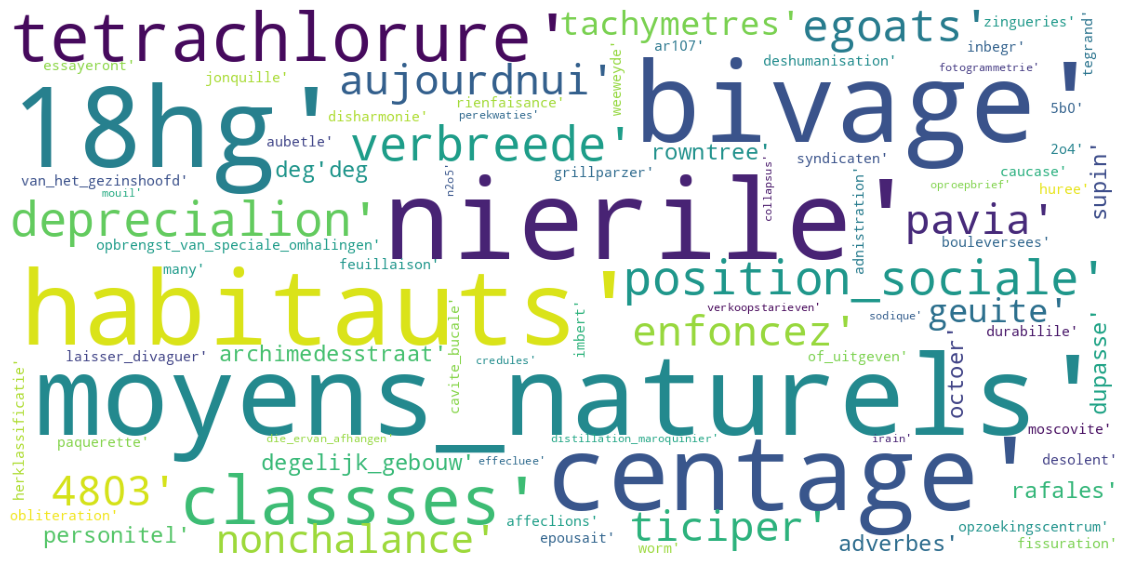

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(most_similar_words)

In [43]:
model.wv.most_similar("boucher", topn=10)

[('charcutier', 0.7203589081764221),
 ('cabaretier', 0.71677565574646),
 ('tailleur', 0.689329981803894),
 ('cordonnier', 0.6871086359024048),
 ('menuisier', 0.6824864149093628),
 ('serrurier', 0.6752164959907532),
 ('batelier', 0.6662552356719971),
 ('macon', 0.6631236672401428),
 ('boulanger', 0.6541011333465576),
 ('tapissier', 0.6519757509231567)]

In [44]:
model.wv.most_similar("platonisme", topn=10)

[('herbauts', 0.915190577507019),
 ('zut', 0.9150223135948181),
 ('lauters_pavie', 0.9118379950523376),
 ('moxhet', 0.9110493659973145),
 ('alder', 0.9100977778434753),
 ('eice', 0.9095739722251892),
 ('xeeckx', 0.9095534682273865),
 ('georges_jamin', 0.9091913104057312),
 ('vandervloet', 0.9091655611991882),
 ('cimenteur', 0.9085382223129272)]

In [45]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('huy', 0.6421297192573547), ('paris', 0.6192587018013), ('lille', 0.6176697611808777), ('londres', 0.6072437763214111), ('tournai', 0.6006607413291931), ('liege', 0.5959431529045105), ('ostende', 0.5860828161239624), ('verviers', 0.578991174697876), ('manchester', 0.5722219347953796), ('gand', 0.5703621506690979)]


In [33]:
print(model.wv.most_similar(positive=['bruxelles', 'espagne'], negative=['belgique']))

[('huy', 0.5839082598686218), ('ostende', 0.5450161099433899), ('thudinie', 0.541573166847229), ('prague', 0.5410814881324768), ('thotel', 0.5289410948753357), ('ypres', 0.523231565952301), ('iiotel', 0.520617663860321), ('vorde', 0.5078517198562622), ('flemalle', 0.507148802280426), ('manufacturiere', 0.501289427280426)]


In [34]:
print(model.wv.most_similar(positive=['bruxelles', 'allemagne'], negative=['belgique']))

[('ostende', 0.6314916014671326), ('hambourg', 0.6015723943710327), ('londres', 0.5773783922195435), ('huy', 0.5761055946350098), ('liege', 0.5690155625343323), ('manchester', 0.5626962184906006), ('manufacturiere', 0.5598292946815491), ('lille', 0.5587208271026611), ('prague', 0.5495508313179016), ('gand', 0.5426905751228333)]


In [35]:
print(model.wv.most_similar(positive=['bruxelles', 'italie'], negative=['belgique']))

[('ostende', 0.640987753868103), ('huy', 0.6076509952545166), ('lille', 0.595402181148529), ('ypres', 0.57524573802948), ('iiotel', 0.5674821734428406), ('prague', 0.5623140335083008), ('manchester', 0.5619288086891174), ('manufacturiere', 0.5616102814674377), ('strasbourg', 0.5557840466499329), ('liege', 0.5550907850265503)]


In [36]:
print(model.wv.most_similar(positive=['bruxelles', 'russie'], negative=['belgique']))

[('prague', 0.6297631859779358), ('ostende', 0.6173080205917358), ('huy', 0.596226155757904), ('manufacturiere', 0.5713881254196167), ('vorde', 0.5713174939155579), ('schaerbeek', 0.5606380105018616), ('manchester', 0.5578584671020508), ('aux_confins', 0.5560258030891418), ('haut', 0.540076732635498), ('binche', 0.5330942869186401)]


In [37]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('obeissance', 0.6023113131523132), ('<<_je_jure', 0.5920091271400452), ('peuple_belge', 0.5707917809486389), ('bon_sens', 0.5461737513542175), ('imperatif', 0.5401242971420288), ('temoignage', 0.5381085276603699), ('respect', 0.531464695930481), ('bel_exemple', 0.5273416638374329), ('desinteressement', 0.5230734348297119), ('attachement', 0.5229159593582153)]


In [38]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('je_jure_fidelite', 0.5852400064468384), ('obeissance', 0.5750858187675476), ('<<_je_jure', 0.5277116894721985), ('sauce', 0.5146341323852539), ('famille_royale', 0.5022656917572021), ('constance', 0.500534176826477), ('liberte_individuelle', 0.49098703265190125), ('societe_philanthropique', 0.48904356360435486), ('jure_fidelite', 0.4882783591747284), ('serment_suivant', 0.48586180806159973)]


In [39]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('terrasse', 0.6444504261016846), ('douche', 0.6420778632164001), ('loge', 0.6418038010597229), ('fenetre', 0.64142906665802), ('mansarde', 0.6320722103118896), ('cave', 0.6290919184684753), ('chaudiere', 0.6265798211097717), ('cloison', 0.6193347573280334), ('citerne', 0.6146482825279236), ('laverie', 0.594642698764801)]


In [40]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('instrument', 0.648766279220581), ('homme_politique', 0.6487466096878052), ('individu', 0.6445953249931335), ('artiste', 0.6387041211128235), ('interet_particulier', 0.6321699023246765), ('jurisconsulte', 0.6215745806694031), ('optimisme', 0.619702160358429), ('orgueil', 0.6146212220191956), ('outil', 0.6125547885894775), ('element', 0.6110112071037292)]


In [41]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('mere', 0.7071201801300049), ('fille', 0.661115288734436), ('maman', 0.6380407214164734), ('servante', 0.6277881860733032), ('maladie', 0.6253735423088074), ('jeune_fille', 0.6191787719726562), ('premiere_communion', 0.6110782027244568), ('pensionnaire', 0.607059895992279), ('soeur', 0.59940105676651), ('famille', 0.5957236886024475)]


#### Modèle 4 du tp3 (100-13)

In [20]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=100, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=13, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 58min 15s, sys: 3min 9s, total: 1h 1min 24s
Wall time: 19min 14s


In [21]:
# outfile = f"../data/bulletins_tp3_4.model"
# model.save(outfile)

In [70]:
model = Word2Vec.load("../data/bulletins_tp3_4.model")

In [23]:
model.wv.similarity("boucher", "boulanger")

0.6894763

In [24]:
model.wv.similarity("homme", "femme")

0.5139492

In [25]:
model.wv.similarity("voiture", "carrosse")

0.36424264

In [26]:
model.wv.similarity("voiture", "chien")

0.48760676

In [27]:
model.wv.most_similar("bruxelles", topn=10)

[('bruxelle', 0.6245981454849243),
 ('nivelles', 0.6151034832000732),
 ('rruxelles', 0.6131613850593567),
 ('liege', 0.6117175221443176),
 ('manufacturiere', 0.611532986164093),
 ('bruxe', 0.6067845821380615),
 ('dette_active', 0.5983333587646484),
 ('xelles', 0.5959808230400085),
 ('laeken', 0.5916270017623901),
 ('bruxeles', 0.5790594816207886)]

In [28]:
model.wv.most_similar("boucher", topn=10)

[('charcutier', 0.7176762223243713),
 ('serrurier', 0.7069606781005859),
 ('cabaretier', 0.6978020071983337),
 ('boulanger', 0.6894762516021729),
 ('menuisier', 0.6731460690498352),
 ('tailleur', 0.670230507850647),
 ('coiffeur', 0.6694632172584534),
 ('abatteur', 0.6684247851371765),
 ('cordonnier', 0.6652677059173584),
 ('batelier', 0.6597355008125305)]

In [29]:
model.wv.most_similar("platonisme", topn=10)

[('memoriam', 0.9293033480644226),
 ('indigena', 0.9271607398986816),
 ('sartori', 0.926234245300293),
 ('kretzschmar', 0.9246671199798584),
 ('lnventaris', 0.922118067741394),
 ('konigl', 0.9211611151695251),
 ('erchem', 0.9204046130180359),
 ('nemingen', 0.9197832942008972),
 ('torenkruis', 0.9192084670066833),
 ('macker', 0.9191706776618958)]

In [30]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('londres', 0.6029162406921387), ('manchester', 0.6002193093299866), ('liege', 0.5949788093566895), ('paris', 0.5923264026641846), ('hambourg', 0.5783761739730835), ('ostende', 0.5692737698554993), ('huy', 0.5623244643211365), ('lille', 0.5608959197998047), ('prague', 0.5584180951118469), ('tournai', 0.5457510948181152)]


In [71]:
print(model.wv.most_similar(positive=['bruxelles', 'espagne'], negative=['belgique']))

[('carabain', 0.5113374590873718), ('ypres', 0.5078569054603577), ('ostende', 0.49739864468574524), ('baudouin', 0.4965556561946869), ('tournai', 0.49541521072387695), ('dantzig', 0.49451330304145813), ('varsovie', 0.4906974732875824), ('aerschot', 0.4774479866027832), ('dampierre', 0.47439342737197876), ('audenaerde', 0.4721287786960602)]


In [72]:
print(model.wv.most_similar(positive=['bruxelles', 'allemagne'], negative=['belgique']))

[('ostende', 0.5902448892593384), ('hambourg', 0.5635671019554138), ('manchester', 0.5483006238937378), ('londres', 0.5309250354766846), ('liege', 0.5296352505683899), ('amsterdam', 0.5255591869354248), ('aux_confins', 0.5165202021598816), ('huy', 0.5079426765441895), ('lille', 0.5069329142570496), ('paris', 0.4950019121170044)]


In [73]:
print(model.wv.most_similar(positive=['bruxelles', 'italie'], negative=['belgique']))

[('ostende', 0.6064270734786987), ('tournai', 0.5685453414916992), ('lille', 0.564100980758667), ('manchester', 0.5583289861679077), ('liege', 0.5498932600021362), ('manufacturiere', 0.5436027646064758), ('basse', 0.5346233248710632), ('huy', 0.5344225168228149), ('ypres', 0.530640184879303), ('amsterdam', 0.5283356308937073)]


In [74]:
print(model.wv.most_similar(positive=['bruxelles', 'russie'], negative=['belgique']))

[('ostende', 0.5779991149902344), ('manchester', 0.5659915804862976), ('prague', 0.5576806664466858), ('schaerbeek', 0.5554612874984741), ('tournai', 0.5372169613838196), ('lille', 0.5324880480766296), ('haut', 0.5320874452590942), ('cologne', 0.5166338086128235), ('huy', 0.5127685070037842), ('liege', 0.5096699595451355)]


In [31]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('obeissance', 0.605998158454895), ('<<_je_jure', 0.5841607451438904), ('peuple_belge', 0.5590676665306091), ('sol_natal', 0.5548775792121887), ('juste_hommage', 0.5513530969619751), ('prestige', 0.5393761396408081), ('desinteressement', 0.5329120755195618), ('instinct', 0.5297734141349792), ('bon_sens', 0.5261308550834656), ('citoyen', 0.5243722200393677)]


In [32]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('obeissance', 0.6290702223777771), ('je_jure_fidelite', 0.5885182023048401), ('<<_je_jure', 0.5691977739334106), ('sauce', 0.5435115694999695), ('serment_suivant', 0.5107361078262329), ('documentation_relative', 0.5010335445404053), ('jure_fidelite', 0.49495068192481995), ('constance', 0.48649510741233826), ('cousine', 0.48115071654319763), ('peuple_belge', 0.47819238901138306)]


In [33]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('cave', 0.6766044497489929), ('terrasse', 0.6721158623695374), ('citerne', 0.6573778390884399), ('laverie', 0.6532216668128967), ('loge', 0.6492891311645508), ('fenetre', 0.6460978984832764), ('chaudiere', 0.6155376434326172), ('mansarde', 0.6098559498786926), ('cloison', 0.6096054911613464), ('grande_cour', 0.601954996585846)]


In [34]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('instrument', 0.6630492210388184), ('element', 0.6583802103996277), ('individu', 0.6516796946525574), ('elan', 0.6513887047767639), ('jurisconsulte', 0.6288636326789856), ('homme_politique', 0.6216161251068115), ('homme_illustre', 0.6213032007217407), ('outil', 0.6207229495048523), ('artiste', 0.6187145113945007), ('orgueil', 0.6057250499725342)]


In [35]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('mere', 0.6739556789398193), ('maman', 0.6626560688018799), ('fillette', 0.6312063932418823), ('fille', 0.6264563202857971), ('maladie', 0.6260286569595337), ('pensionnaire', 0.6186718344688416), ('servante', 0.6135286688804626), ('leurs_parents', 0.6006483435630798), ('colonie', 0.5975514650344849), ('orpheline', 0.5905892848968506)]


#### Modèle 5 du tp3 (100-7)

In [37]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=100, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=7, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 1h 5min 4s, sys: 4min 7s, total: 1h 9min 11s
Wall time: 24min 47s


In [38]:
# outfile = f"../data/bulletins_tp3_5.model"
# model.save(outfile)

In [75]:
model = Word2Vec.load("../data/bulletins_tp3_5.model")

In [40]:
model.wv.similarity("boucher", "boulanger")

0.73597544

In [41]:
model.wv.similarity("homme", "femme")

0.4968657

In [42]:
model.wv.similarity("voiture", "carrosse")

0.32512385

In [43]:
model.wv.similarity("voiture", "chien")

0.49683255

In [44]:
model.wv.most_similar("bruxelles", topn=10)

[('rruxelles', 0.6734998822212219),
 ('bruxelle', 0.6661106944084167),
 ('nivelles', 0.6410489082336426),
 ('rilotel', 0.6126345992088318),
 ('liege', 0.6124768257141113),
 ('laeken', 0.6062876582145691),
 ('prague', 0.5905728340148926),
 ('paris', 0.5812634229660034),
 ('bruxe', 0.5775205492973328),
 ('thotel', 0.5755437016487122)]

In [45]:
model.wv.most_similar("boucher", topn=10)

[('cabaretier', 0.7500571012496948),
 ('charcutier', 0.7466012835502625),
 ('batelier', 0.7365172505378723),
 ('boulanger', 0.7359753847122192),
 ('cordonnier', 0.7342681288719177),
 ('tailleur', 0.7201100587844849),
 ('menuisier', 0.7160308957099915),
 ('serrurier', 0.7102100849151611),
 ('marchand', 0.7081350684165955),
 ('tapissier', 0.7031669020652771)]

In [46]:
model.wv.most_similar("platonisme", topn=10)

[('openbare_tekoopstelling', 0.9188531637191772),
 ('45707', 0.9182823300361633),
 ('andrade', 0.9179937243461609),
 ('maison_hoguet', 0.9170889854431152),
 ('chapeliers_cinematographes', 0.9166592359542847),
 ('joh', 0.9159383177757263),
 ('zwanen', 0.9153969883918762),
 ('guiseppe', 0.9151684641838074),
 ('alder', 0.9139969348907471),
 ('chafitre', 0.9138032793998718)]

In [47]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('londres', 0.6196915507316589), ('huy', 0.6139494180679321), ('paris', 0.612241268157959), ('prague', 0.6118791103363037), ('strasbourg', 0.6046821475028992), ('liege', 0.6004124879837036), ('ostende', 0.5979876518249512), ('tournai', 0.5954980850219727), ('verviers', 0.5954693555831909), ('lille', 0.5920859575271606)]


In [76]:
print(model.wv.most_similar(positive=['bruxelles', 'espagne'], negative=['belgique']))

[('prague', 0.5503891110420227), ('ostende', 0.5318549275398254), ('irlande', 0.5224217176437378), ('ypres', 0.5218260884284973), ('thotel', 0.5095411539077759), ('tournai', 0.5063199996948242), ('strasbourg', 0.49888157844543457), ('argenteuil', 0.49751147627830505), ('vesale', 0.48966410756111145), ('edimbourg', 0.4892043471336365)]


In [77]:
print(model.wv.most_similar(positive=['bruxelles', 'allemagne'], negative=['belgique']))

[('ostende', 0.6012612581253052), ('prague', 0.5643337965011597), ('londres', 0.5528656840324402), ('paris', 0.5347831845283508), ('lille', 0.5164390206336975), ('amsterdam', 0.5154851675033569), ('huy', 0.5146849155426025), ('liege', 0.5146468877792358), ('hambourg', 0.5100196599960327), ('3tiia', 0.5036190152168274)]


In [78]:
print(model.wv.most_similar(positive=['bruxelles', 'italie'], negative=['belgique']))

[('ostende', 0.630800724029541), ('strasbourg', 0.6188726425170898), ('tournai', 0.5842278003692627), ('prague', 0.5816137790679932), ('verviers', 0.575137734413147), ('huy', 0.5739449262619019), ('lille', 0.5552613735198975), ('paris', 0.5530115962028503), ('amsterdam', 0.5458919405937195), ('thotel', 0.5422924160957336)]


In [79]:
print(model.wv.most_similar(positive=['bruxelles', 'russie'], negative=['belgique']))

[('prague', 0.6325637698173523), ('schaerbeek', 0.6094449162483215), ('ostende', 0.5848404169082642), ('luxembourg', 0.5727669596672058), ('laeken', 0.5571810007095337), ('forest', 0.5558596253395081), ('cologne', 0.5432012677192688), ('louvain', 0.542707622051239), ('vorde', 0.5427005887031555), ('verviers', 0.5415210723876953)]


In [48]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('obeissance', 0.5728465914726257), ('<<_je_jure', 0.5694021582603455), ('imperatif', 0.5405074954032898), ('desinteressement', 0.5380254983901978), ('peuple_flamand', 0.5256156921386719), ('episode', 0.5096283555030823), ('constitutionnel', 0.5089327096939087), ('je_jure_fidelite', 0.503819465637207), ('instinct', 0.499616801738739), ('ensemble_architectural', 0.49446341395378113)]


In [49]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('obeissance', 0.5828089118003845), ('famille_royale', 0.554032564163208), ('sauce', 0.5483404994010925), ('monarchie', 0.5462076663970947), ('je_jure_fidelite', 0.5453361868858337), ('<<_je_jure', 0.5133175253868103), ('cantine', 0.5123889446258545), ('compagne', 0.5098216533660889), ('tarte', 0.5086079835891724), ('victoire', 0.5077992677688599)]


In [50]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('cellule', 0.6800757646560669), ('loge', 0.670630693435669), ('terrasse', 0.6701534390449524), ('douche', 0.6575928926467896), ('cave', 0.651539146900177), ('fenetre', 0.6492428779602051), ('mansarde', 0.6422395706176758), ('garderie', 0.6345840096473694), ('citerne', 0.623020350933075), ('laverie', 0.6198109984397888)]


In [51]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('individu', 0.669407069683075), ('etre_humain', 0.6576298475265503), ('optimisme', 0.6521869897842407), ('instrument', 0.6490356922149658), ('element', 0.6462197303771973), ('homme_politique', 0.644122838973999), ('interet_particulier', 0.6403871178627014), ('outil', 0.6402451992034912), ('jurisconsulte', 0.6166369915008545), ('instinct', 0.6153025031089783)]


In [52]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('mere', 0.6830453872680664), ('maman', 0.6731988787651062), ('fille', 0.6685454845428467), ('fillette', 0.6308883428573608), ('servante', 0.6275987029075623), ('maladie', 0.6263610124588013), ('jeune_fille', 0.6254672408103943), ('pensionnaire', 0.6240344643592834), ('colonie', 0.6148338913917542), ('premiere_communion', 0.5985870957374573)]


In [54]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme']))

[('eoi', 0.550216019153595), ('mere', 0.5251489877700806), ('iication', 0.49920013546943665), ('sentence', 0.48368674516677856), ('fille', 0.4814489483833313), ('legion_nationale', 0.48094841837882996), ('general_belliard', 0.48025375604629517), ('louve', 0.47936856746673584), ('defunt', 0.4689710736274719), ('famille_royale', 0.4682580232620239)]


In [55]:
model.wv.most_similar("reine", topn=10)

[('beine', 0.7733144760131836),
 ('renaissance', 0.765352725982666),
 ('brabanconne', 0.7470369935035706),
 ('heine', 0.7218537926673889),
 ('reine_elisabeth', 0.7036610245704651),
 ('chevalerie', 0.6953015923500061),
 ('sarriette', 0.6943184733390808),
 ('clairiere', 0.6917508244514465),
 ('madrid', 0.6880948543548584),
 ('colombie', 0.6780986189842224)]

#### Modèle 6 du tp3 (32-7)

In [17]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=7, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 35min 34s, sys: 1min 30s, total: 37min 4s
Wall time: 12min 58s


In [18]:
outfile = f"../data/bulletins_tp3_6.model"
model.save(outfile)

In [80]:
model = Word2Vec.load("../data/bulletins_tp3_6.model")

In [20]:
model.wv.similarity("boucher", "boulanger")

0.89795554

In [21]:
model.wv.similarity("homme", "femme")

0.61819994

In [22]:
model.wv.similarity("voiture", "carrosse")

0.45652765

In [23]:
model.wv.most_similar("bruxelles", topn=10)

[('laeken', 0.8272863030433655),
 ('liege', 0.7421290278434753),
 ('nivelles', 0.7203897833824158),
 ('considere_comme_officiel', 0.7201547622680664),
 ('paris', 0.7147777080535889),
 ('rruxelles', 0.7025668025016785),
 ('israeliens', 0.6887220740318298),
 ('gand', 0.6838312745094299),
 ('des_communes_limitrophes', 0.6833171248435974),
 ('charleroi', 0.6721785068511963)]

In [24]:
model.wv.most_similar("boucher", topn=10)

[('batelier', 0.9065051674842834),
 ('boulanger', 0.8979554772377014),
 ('tailleur', 0.8750821352005005),
 ('menuisier', 0.8689311742782593),
 ('macon', 0.8651826977729797),
 ('poissonnier', 0.859420895576477),
 ('charcutier', 0.8574626445770264),
 ('marchand', 0.8517792820930481),
 ('terrassier', 0.8517159819602966),
 ('forgeron', 0.8467037081718445)]

In [25]:
model.wv.most_similar("platonisme", topn=10)

[('buitenzetten', 0.9655938744544983),
 ('speelgoed', 0.9611073732376099),
 ('ued', 0.9604259729385376),
 ('paleizenplaats', 0.9593244194984436),
 ('guilielmus', 0.9587242603302002),
 ('evolutie_zijnde', 0.9582727551460266),
 ('belgicoe', 0.9582096338272095),
 ('binnenkomen', 0.958014190196991),
 ('argentre', 0.9577236175537109),
 ('verwarm', 0.9567806720733643)]

In [27]:
model.wv.most_similar("urinoir", topn=10)

[('evier', 0.9170675277709961),
 ('auvent', 0.9157642722129822),
 ('ascenseur', 0.8936619162559509),
 ('espace_libre', 0.8721005916595459),
 ('arbre', 0.8624054789543152),
 ('hangar', 0.8540787100791931),
 ('echafaudage', 0.8516961336135864),
 ('enfoncement', 0.8513393998146057),
 ('preau_couvert', 0.8486384153366089),
 ('appartement', 0.8403266668319702)]

In [28]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('huy', 0.8089704513549805), ('manchester', 0.7912181615829468), ('ostende', 0.7875585556030273), ('prague', 0.7845705151557922), ('liverpool', 0.7595359683036804), ('verviers', 0.7518717646598816), ('lille', 0.7506416440010071), ('aux_confins', 0.7472284436225891), ('mayence', 0.7469117641448975), ('seraing', 0.7336947917938232)]


In [81]:
print(model.wv.most_similar(positive=['bruxelles', 'espagne'], negative=['belgique']))

[('ostende', 0.7686001658439636), ('alost', 0.7631637454032898), ('anvers', 0.7440226078033447), ('ypres', 0.7353346943855286), ('huy', 0.7110108733177185), ('amsterdam', 0.7062295079231262), ('arlon', 0.7023181915283203), ('avenues_franklin', 0.7015784978866577), ('tournai', 0.6952449083328247), ('prague', 0.6932228207588196)]


In [82]:
print(model.wv.most_similar(positive=['bruxelles', 'allemagne'], negative=['belgique']))

[('ostende', 0.7607871890068054), ('anvers', 0.7428261041641235), ('aux_confins', 0.7409296631813049), ('charleroi', 0.7292239665985107), ('manchester', 0.723929226398468), ('amsterdam', 0.7217715382575989), ('huy', 0.7145229578018188), ('hambourg', 0.7141580581665039), ('meirelbeke', 0.6958719491958618), ('ouest', 0.6941896080970764)]


In [83]:
print(model.wv.most_similar(positive=['bruxelles', 'italie'], negative=['belgique']))

[('ostende', 0.8462244868278503), ('alost', 0.8031744956970215), ('anvers', 0.7997011542320251), ('amsterdam', 0.7799228429794312), ('huy', 0.7735434770584106), ('prague', 0.7611766457557678), ('verviers', 0.7560798525810242), ('ypres', 0.7532651424407959), ('manchester', 0.7468370795249939), ('tournai', 0.7415379881858826)]


In [84]:
print(model.wv.most_similar(positive=['bruxelles', 'russie'], negative=['belgique']))

[('aux_confins', 0.8025550842285156), ('charleroi', 0.7869207859039307), ('ostende', 0.7768861651420593), ('luxembourg', 0.7727224230766296), ('mayence', 0.7650524377822876), ('alost', 0.7636563181877136), ('cureghem', 0.7591552734375), ('louvain', 0.7495631575584412), ('prague', 0.7449910044670105), ('binche', 0.7439122200012207)]


In [29]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('<<_je_jure', 0.7679821848869324), ('plus_profond', 0.7537145614624023), ('mepris', 0.7494698166847229), ('verbe', 0.743941605091095), ('magnifique_elan', 0.7403584122657776), ('banc', 0.7284218072891235), ('serment_suivant', 0.7214251756668091), ('peuple_belge', 0.7196507453918457), ('transvaal', 0.7193516492843628), ('supplice', 0.715126633644104)]


In [30]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('famille_royale', 0.7191616892814636), ('saintete', 0.7019950747489929), ('propriete_immobiliere', 0.6927812099456787), ('commandite_par_actions', 0.6819890737533569), ('liberte_individuelle', 0.6751049757003784), ('circonscription_militaire', 0.6728301048278809), ('commission_paritaire', 0.6697050929069519), ('corporation', 0.6657859086990356), ('naturalisation_ordinaire', 0.6646279096603394), ('case_placee', 0.6594612002372742)]


In [31]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('glaciere', 0.8750630021095276), ('terrasse', 0.862410843372345), ('mansarde', 0.8457068204879761), ('cloison_vitree', 0.8455638289451599), ('tremie', 0.8452608585357666), ('chaudiere', 0.8437645435333252), ('cave', 0.8344993591308594), ('douche', 0.83009272813797), ('galerie_couverte', 0.8284509181976318), ('garderie', 0.820063054561615)]


In [32]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('interet_particulier', 0.7917542457580566), ('soin_jaloux', 0.7786352634429932), ('honnete_homme', 0.7778093218803406), ('ecrivain', 0.7737045884132385), ('individu', 0.7714208364486694), ('oubli', 0.7707334756851196), ('instinct', 0.7702805399894714), ('elan', 0.7680544853210449), ('etre_humain', 0.7662696242332458), ('instrument', 0.7644329071044922)]


In [33]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('fille', 0.8289195895195007), ('jeune_fille', 0.8238834142684937), ('classe_flamande', 0.8093726634979248), ('fillette', 0.7889494895935059), ('profession', 0.7886649370193481), ('nationalite_etrangere', 0.7829521894454956), ('maman', 0.7779103517532349), ('leur_mere', 0.7776534557342529), ('mere', 0.7765055298805237), ('orpheline', 0.7741913199424744)]


In [34]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme']))

[('famille_royale', 0.7027952075004578), ('donatrice', 0.6996607780456543), ('gourde', 0.6745128035545349), ('vdle', 0.6718039512634277), ('conference_monetaire', 0.671133279800415), ('grande_kermesse', 0.6604625582695007), ('circonscription_militaire', 0.6545321345329285), ('defunte', 0.6509469151496887), ('division_militaire', 0.6480212211608887), ('naturalisation', 0.6454724669456482)]


#### Modèle 7 du tp3 (32-13)

In [35]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=13, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 55min 21s, sys: 3min 51s, total: 59min 12s
Wall time: 20min 42s


In [36]:
outfile = f"../data/bulletins_tp3_7.model"
model.save(outfile)

In [85]:
model = Word2Vec.load("../data/bulletins_tp3_7.model")

In [38]:
model.wv.similarity("boucher", "boulanger")

0.8502226

In [39]:
model.wv.similarity("homme", "femme")

0.6236469

In [40]:
model.wv.similarity("voiture", "carrosse")

0.42254362

In [41]:
model.wv.most_similar("bruxelles", topn=10)

[('laeken', 0.8099821209907532),
 ('liege', 0.7758094668388367),
 ('nivelles', 0.7717729806900024),
 ('mons', 0.7525895833969116),
 ('gand', 0.7385832667350769),
 ('ostende', 0.7286675572395325),
 ('louvain', 0.7222659587860107),
 ('bruxelloise', 0.7156859040260315),
 ('son_siege', 0.7095896601676941),
 ('tirlemont', 0.7035690546035767)]

In [42]:
model.wv.most_similar("boucher", topn=10)

[('tailleur', 0.8838116526603699),
 ('menuisier', 0.8788487911224365),
 ('batelier', 0.877282440662384),
 ('fabricant', 0.8770335912704468),
 ('charcutier', 0.8711507320404053),
 ('macon', 0.8694088459014893),
 ('marchand', 0.8613522052764893),
 ('boulanger', 0.850222647190094),
 ('cordonnier', 0.848287045955658),
 ('serrurier', 0.8454512357711792)]

In [43]:
model.wv.most_similar("platonisme", topn=10)

[('werveke', 0.965522825717926),
 ('rudolph', 0.9625495672225952),
 ('fellows', 0.9603227972984314),
 ('place_eoyale', 0.9589579105377197),
 ('bijzondere_geschillen', 0.9580908417701721),
 ('arcadie', 0.9573949575424194),
 ('konigl', 0.95736163854599),
 ('stopzetting_van_handelsaktiviteit', 0.9567670822143555),
 ('montagu', 0.9567061066627502),
 ('dekin', 0.956697404384613)]

In [45]:
model.wv.most_similar("urinoir", topn=10)

[('ascenseur', 0.8841036558151245),
 ('auvent', 0.8802363276481628),
 ('evier', 0.8710079789161682),
 ('pissoir', 0.8626327514648438),
 ('escalier', 0.8528569340705872),
 ('corridor', 0.8493427038192749),
 ('couloir', 0.846498429775238),
 ('lavabo', 0.8454853296279907),
 ('hangar', 0.844763994216919),
 ('grillage', 0.8445080518722534)]

In [46]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('ostende', 0.837738573551178), ('huy', 0.8267396688461304), ('gand', 0.8100168704986572), ('alost', 0.7983483076095581), ('liege', 0.7982513904571533), ('manchester', 0.792993426322937), ('eupen', 0.7898467779159546), ('tervueren', 0.7781599164009094), ('verviers', 0.7754904627799988), ('flandres', 0.7630794644355774)]


In [86]:
print(model.wv.most_similar(positive=['bruxelles', 'espagne'], negative=['belgique']))

[('alost', 0.7983243465423584), ('ostende', 0.7734858989715576), ('huy', 0.7656322121620178), ('eupen', 0.7447236776351929), ('binche', 0.7324212193489075), ('tournai', 0.7304689288139343), ('tervueren', 0.7264571785926819), ('arlon', 0.7152998447418213), ('anvers', 0.7124070525169373), ('baudouin', 0.7093945145606995)]


In [87]:
print(model.wv.most_similar(positive=['bruxelles', 'allemagne'], negative=['belgique']))

[('ostende', 0.8129523992538452), ('anvers', 0.7710670828819275), ('alost', 0.765917181968689), ('huy', 0.755611002445221), ('gand', 0.7509430646896362), ('aux_confins', 0.7475512027740479), ('tervueren', 0.7463960647583008), ('manchester', 0.7410745024681091), ('flandres', 0.7385588884353638), ('liege', 0.7351776957511902)]


In [88]:
print(model.wv.most_similar(positive=['bruxelles', 'italie'], negative=['belgique']))

[('ostende', 0.8568642139434814), ('alost', 0.8339364528656006), ('huy', 0.8163793087005615), ('manchester', 0.7815848588943481), ('verviers', 0.7815176248550415), ('anvers', 0.780205249786377), ('amsterdam', 0.7756264209747314), ('tervueren', 0.773829460144043), ('tournai', 0.7621212005615234), ('binche', 0.7588929533958435)]


In [89]:
print(model.wv.most_similar(positive=['bruxelles', 'russie'], negative=['belgique']))

[('ostende', 0.8269484043121338), ('huy', 0.8024683594703674), ('alost', 0.7994868755340576), ('tervueren', 0.7978609800338745), ('manchester', 0.7870156764984131), ('aux_confins', 0.7866812348365784), ('koekelberg', 0.7857340574264526), ('forest', 0.7849729657173157), ('eupen', 0.7733600735664368), ('gand', 0.7599501609802246)]


In [47]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('obeissance', 0.782763659954071), ('peuple_belge', 0.7765308022499084), ('mot', 0.7754769921302795), ('<<_je_jure', 0.7686077356338501), ('liberalisme', 0.7673251032829285), ('serment_suivant', 0.764306366443634), ('traitent_constamment', 0.7615564465522766), ('communisme', 0.7602001428604126), ('mepris', 0.7465515732765198), ('je_jure_fidelite', 0.7424283027648926)]


In [48]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('famille_royale', 0.7165464162826538), ('naturalisation_ordinaire', 0.6563760638237), ('circonscription_militaire', 0.654526948928833), ('prescription_reglementaire', 0.6513457298278809), ('liberte_individuelle', 0.640577495098114), ('division_judiciaire', 0.6325024962425232), ('pohlman', 0.6273826956748962), ('courtiers', 0.626354455947876), ('devront_se_disperser', 0.6232321858406067), ('seront_ensuite_vires', 0.6066663861274719)]


In [49]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('cave', 0.849334716796875), ('mansarde', 0.8300670981407166), ('terrasse', 0.8226112723350525), ('maison', 0.8106406927108765), ('toiture_vitree', 0.8030121922492981), ('cloison', 0.7976855635643005), ('maison_voisine', 0.7965577840805054), ('chaudiere', 0.7929766774177551), ('baignoire', 0.7919986248016357), ('tremie', 0.7915893197059631)]


In [50]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('outil', 0.8143144845962524), ('ecrivain', 0.7914820313453674), ('instrument', 0.7895579934120178), ('renom', 0.7823542952537537), ('geste', 0.7799872159957886), ('elan', 0.7752275466918945), ('honnete_homme', 0.7731138467788696), ('but_educatif', 0.7679823637008667), ('element', 0.7674082517623901), ('bonheur', 0.7594817280769348)]


In [51]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('orpheline', 0.781629204750061), ('leur_mere', 0.7696054577827454), ('maladie', 0.7659868001937866), ('pension_mensuelle', 0.7651069760322571), ('incapacite', 0.7630898952484131), ('legere_retribution', 0.7606083154678345), ('mere', 0.7490358352661133), ('fille', 0.7489858865737915), ('maman', 0.747954785823822), ('servante', 0.744658887386322)]


In [52]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme']))

[('demoiselle_pauline', 0.7312612533569336), ('brumaire_an_x', 0.7196619510650635), ('messe_solennelle', 0.6956167817115784), ('mai_1841', 0.6879915595054626), ('3iorris', 0.6595137119293213), ('famille_royale', 0.6356023550033569), ('decembre_1825', 0.6348997354507446), ('aout_1954', 0.633337140083313), ('demoiselle', 0.6314735412597656), ('ordonnance_rendue', 0.6287355422973633)]


In [53]:
print(model.wv.most_similar(positive=['reine', 'homme'], negative=['femme']))

[('madrid', 0.8002997040748596), ('roi_albert', 0.783388078212738), ('lorraine', 0.7800635099411011), ('petit_bonhomme', 0.761467695236206), ('prince_albert', 0.7577899098396301), ('ducal', 0.7558925151824951), ('nassau', 0.7556396722793579), ('rogier', 0.7499505281448364), ('prince_charles', 0.7421935796737671), ('civet', 0.7290101647377014)]


In [54]:
print(model.wv.most_similar(positive=['fidelite', 'joie'], negative=['obeissance']))

[('curiosite', 0.8759246468544006), ('tenacite', 0.8670616745948792), ('merveilleuse', 0.8335537314414978), ('offensive', 0.8256468176841736), ('douleur', 0.8252801299095154), ('fierte', 0.8141542077064514), ('gloire', 0.8129704594612122), ('priere', 0.7978666424751282), ('tristesse', 0.7959681749343872), ('cordialite', 0.7945759892463684)]


#### Modèle 8 du tp3 (300-13)

In [90]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=300, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=13, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 1h 35min 56s, sys: 3min 15s, total: 1h 39min 11s
Wall time: 28min 24s


In [91]:
outfile = f"../data/bulletins_tp3_8.model"
model.save(outfile)

In [92]:
model = Word2Vec.load("../data/bulletins_tp3_8.model")

In [93]:
model.wv.similarity("boucher", "boulanger")

0.5416301

In [94]:
model.wv.similarity("homme", "femme")

0.42050081

In [95]:
model.wv.similarity("voiture", "carrosse")

0.2972208

In [96]:
model.wv.most_similar("bruxelles", topn=10)

[('rruxelles', 0.5298047661781311),
 ('liege', 0.5063232779502869),
 ('manufacturiere', 0.4945032298564911),
 ('nivelles', 0.49449121952056885),
 ('xelles', 0.4781859219074249),
 ('huy', 0.47500231862068176),
 ('prague', 0.46621251106262207),
 ('tournai', 0.46375542879104614),
 ('aux_confins', 0.4620218873023987),
 ('verviers', 0.4589115381240845)]

In [97]:
model.wv.most_similar("boucher", topn=10)

[('coiffeur', 0.5825369358062744),
 ('marchand', 0.5788270831108093),
 ('cordonnier', 0.5746620297431946),
 ('charcutier', 0.5682214498519897),
 ('tailleur', 0.5602602958679199),
 ('mecanicien', 0.5576831102371216),
 ('abatteur', 0.5565831065177917),
 ('cabaretier', 0.5542455315589905),
 ('serrurier', 0.5494807958602905),
 ('batelier', 0.5425667762756348)]

In [98]:
model.wv.most_similar("platonisme", topn=10)

[('stradae', 0.8677185773849487),
 ('huilen', 0.8668932914733887),
 ('dols', 0.8653469681739807),
 ('infirmiers_laiques', 0.8648837804794312),
 ('buffet_loue', 0.8647048473358154),
 ('calculs_biliaires_autres_affections', 0.8646893501281738),
 ('slov', 0.8646629452705383),
 ('georges_jamin', 0.8642736673355103),
 ('stevelinck', 0.8639476299285889),
 ('nnick', 0.8638356924057007)]

In [99]:
model.wv.most_similar("urinoir", topn=10)

[('auvent', 0.6973203420639038),
 ('pissoir', 0.64595627784729),
 ('ascenseur', 0.634244978427887),
 ('evier', 0.6341051459312439),
 ('grillage', 0.6311922669410706),
 ('echafaudage', 0.6191889643669128),
 ('lavabo', 0.6122613549232483),
 ('baraquement', 0.6086590886116028),
 ('hangar', 0.6033166646957397),
 ('ecran', 0.5991698503494263)]

In [100]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('liege', 0.49227625131607056), ('huy', 0.48754826188087463), ('verviers', 0.4783484935760498), ('londres', 0.47774073481559753), ('lille', 0.4582214057445526), ('prague', 0.45384982228279114), ('hambourg', 0.44368886947631836), ('ostende', 0.44294893741607666), ('gand', 0.4418032169342041), ('tournai', 0.4411778450012207)]


In [101]:
print(model.wv.most_similar(positive=['bruxelles', 'espagne'], negative=['belgique']))

[('tournai', 0.43133291602134705), ('aerschot', 0.4103463590145111), ('ostende', 0.4084432125091553), ('prague', 0.40805718302726746), ('amsterdam', 0.4013154208660126), ('malines', 0.3904341161251068), ('alost', 0.38874536752700806), ('huy', 0.3849520981311798), ('utrecht', 0.3774191737174988), ('verviers', 0.3767273724079132)]


In [102]:
print(model.wv.most_similar(positive=['bruxelles', 'allemagne'], negative=['belgique']))

[('ostende', 0.4621756970882416), ('liege', 0.44640374183654785), ('hambourg', 0.4343544840812683), ('amsterdam', 0.4315454363822937), ('huy', 0.4298105835914612), ('aux_confins', 0.4243192970752716), ('lille', 0.41776010394096375), ('nivelles', 0.4019663333892822), ('gand', 0.40146708488464355), ('malines', 0.40143099427223206)]


In [103]:
print(model.wv.most_similar(positive=['bruxelles', 'italie'], negative=['belgique']))

[('ostende', 0.49988478422164917), ('lille', 0.48353469371795654), ('amsterdam', 0.46759966015815735), ('liege', 0.4652335047721863), ('verviers', 0.46498000621795654), ('tournai', 0.46385297179222107), ('utrecht', 0.4567834138870239), ('huy', 0.45547249913215637), ('prague', 0.4456019699573517), ('hambourg', 0.43065595626831055)]


In [104]:
print(model.wv.most_similar(positive=['bruxelles', 'russie'], negative=['belgique']))

[('prague', 0.4632329046726227), ('ostende', 0.4580478370189667), ('verviers', 0.44994157552719116), ('tournai', 0.4421530067920685), ('malines', 0.41916778683662415), ('liege', 0.41688865423202515), ('huy', 0.4156561493873596), ('diest', 0.414483904838562), ('aux_confins', 0.4133971333503723), ('nivelles', 0.40915754437446594)]


In [105]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('obeissance', 0.5383955240249634), ('<<_je_jure', 0.48328474164009094), ('peuple_belge', 0.48155802488327026), ('serment_suivant', 0.4357927739620209), ('respect', 0.420331209897995), ('je_jure_fidelite', 0.41517436504364014), ('sol_natal', 0.41515859961509705), ('inspiraient', 0.39937594532966614), ('desinteressement', 0.3958914577960968), ('citoyen', 0.3943515121936798)]


In [106]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('obeissance', 0.5479778051376343), ('<<_je_jure', 0.5106279253959656), ('je_jure_fidelite', 0.46132656931877136), ('serment_suivant', 0.41787591576576233), ('serment_constitutionnel', 0.4045794606208801), ('jure_fidelite', 0.39255285263061523), ('constance', 0.3915352523326874), ('famille_royale', 0.3830355405807495), ('victoire', 0.37493136525154114), ('sauce', 0.3717755079269409)]


In [107]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('fenetre', 0.5451785326004028), ('terrasse', 0.5223769545555115), ('laverie', 0.4952446520328522), ('cloison', 0.4771905243396759), ('mansarde', 0.47389453649520874), ('evier', 0.47031959891319275), ('chaque_etage', 0.4690225124359131), ('cave', 0.4635080099105835), ('vitree', 0.46224045753479004), ('pouponniere', 0.46050044894218445)]


In [108]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('individu', 0.5297693014144897), ('jeune_homme', 0.49008315801620483), ('artiste', 0.4817962348461151), ('instrument', 0.47971001267433167), ('optimisme', 0.47797784209251404), ('homme_politique', 0.46728238463401794), ('quelqu', 0.462742418050766), ('honnete_homme', 0.46216970682144165), ('elan', 0.4619937241077423), ('arbre', 0.4573567807674408)]


In [109]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('mere', 0.5488718152046204), ('fille', 0.5401672124862671), ('fillette', 0.5127921104431152), ('servante', 0.49984821677207947), ('maman', 0.49631649255752563), ('leurs_parents', 0.4925646185874939), ('malade', 0.4775630533695221), ('sa_femme', 0.47013533115386963), ('mariee', 0.46650150418281555), ('enfants', 0.4641094207763672)]


In [110]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme']))

[('mere', 0.43544864654541016), ('fille', 0.42279261350631714), ('eoi', 0.41830456256866455), ('mgr', 0.385509192943573), ('princesse_marie', 0.3703761696815491), ('gouvernement_italien', 0.3689500093460083), ('boi', 0.3687189519405365), ('famille_royale', 0.36710745096206665), ('sa_majeste', 0.358447790145874), ('salut', 0.3582429885864258)]


In [111]:
print(model.wv.most_similar(positive=['reine', 'homme'], negative=['femme']))

[('roi_albert', 0.4634145498275757), ('heine', 0.4395245611667633), ('beine', 0.4345308840274811), ('renaissance', 0.41956615447998047), ('bejar', 0.41585782170295715), ('madrid', 0.40189653635025024), ('imperatrice_charlotte', 0.40186789631843567), ('lieine', 0.40085816383361816), ('homme_eminent', 0.38005363941192627), ('empereur', 0.37904271483421326)]


In [112]:
print(model.wv.most_similar(positive=['fidelite', 'joie'], negative=['obeissance']))

[('fierte', 0.6107153296470642), ('tristesse', 0.6034759879112244), ('douleur', 0.6027112007141113), ('bonte', 0.5828537940979004), ('serenite', 0.5623412132263184), ('vitalite', 0.5620651245117188), ('cordialite', 0.5532791614532471), ('gloire', 0.5529769062995911), ('cordiale', 0.5324522852897644), ('pitie', 0.5314198732376099)]


#### Analyse des modèles sur base des pentagrammes

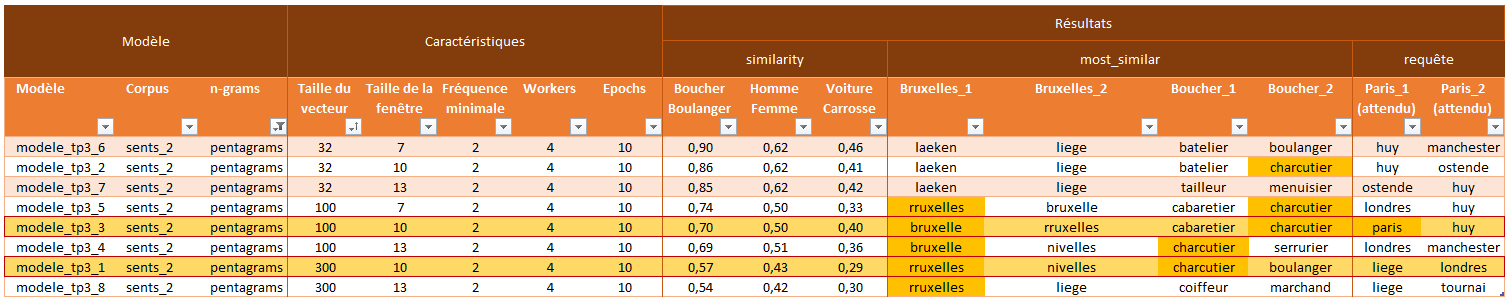

On remarque que - dans le cas des modèles se basant sur les Phrasers itératifs à cinq niveaux - la subtilité des modèles semblent augmenter. Le mot 'charcutier' remonte plus vite dans les résultats. Et le modèle tp3_3 identifie même la capitale de France : Paris. Notons, que le modèle tp3_1 identifie 'aristotélisme' comme étant proche de 'platonisme', mais le modèle semble perdre en précision dans la requête complexe, testant la capitale.

Je décide donc d'explorer plus en profondeur ces deux modèles à l'aide des fonctions 'similarity' et 'most_similar'.

#### Chargement des deux modèles

In [6]:
model_100 = Word2Vec.load("../data/bulletins_tp3_3.model")

In [7]:
model_300 = Word2Vec.load("../data/bulletins_tp3_1.model")

#### Exploration de la fonction 'similarity'

In [8]:
model_100.wv.similarity("pompier", "officier")

0.65211016

In [9]:
model_300.wv.similarity("pompier", "officier")

0.5023073

In [10]:
model_100.wv.similarity("maladie", "convalescence")

0.3494424

In [11]:
model_300.wv.similarity("maladie", "convalescence")

0.2292148

In [12]:
model_100.wv.similarity("maladie", "traitement")

0.31517202

In [13]:
model_300.wv.similarity("maladie", "traitement")

0.2652612

In [14]:
model_100.wv.similarity("ville", "campagne")

0.28434163

In [15]:
model_300.wv.similarity("ville", "campagne")

0.19255131

In [16]:
model_100.wv.similarity("blanc", "noir")

0.8410451

In [17]:
model_300.wv.similarity("blanc", "noir")

0.729584

Nous remarquons que les scores de similarité sont ambigüs. Il peuvent indiquer des scores hauts ou bas pour des mots a priori opposés, bien que proche par nature (exemple: la couleur pour l'opposition entre noir et blanc). Ce score est donc plutôt à utiliser pour tester la compréhension du modèle pour des mots considérés comme proches en français. Selon moi, Pour tester les distances entre des mots éloignés, il vaut mieux utiliser les requêtes complexes.

#### Exploration de la fonction 'most_similar'

Je profite de cette fonction pour explorer des mots fréquents ressortis lors du tp2 afin d'explorer leur "signification" propre à notre corpus. 

In [18]:
model_100.wv.most_similar("assitance", topn=10)

[('iitraordinaires', 0.8524921536445618),
 ('dcmanet', 0.8499798774719238),
 ('ongelijkheid', 0.8495213389396667),
 ('remunerade', 0.8486112952232361),
 ('tassain', 0.847855806350708),
 ('hazee', 0.8456847667694092),
 ('vapereau', 0.8454662561416626),
 ('fontane', 0.8447458744049072),
 ('cavelier', 0.8444737195968628),
 ('costeur', 0.84446120262146)]

In [19]:
model_300.wv.most_similar("assitance", topn=10)

[('soliloque', 0.7464151978492737),
 ('cretift', 0.7448118925094604),
 ('1426i', 0.7249847054481506),
 ('lxxxvin', 0.7245268821716309),
 ('ograpliie', 0.724136233329773),
 ('serviintercommude', 0.7204516530036926),
 ('trv', 0.7201919555664062),
 ('drytaael', 0.7191236019134521),
 ('algeheelheid', 0.7166889905929565),
 ('l120', 0.7151702046394348)]

In [20]:
model_100.wv.most_similar("entretien", topn=10)

[('entrelien', 0.8215510845184326),
 ('tretien', 0.7242748141288757),
 ('enlretien', 0.6861079335212708),
 ('enlrelien', 0.6549329161643982),
 ('entret', 0.6450572609901428),
 ('fentretien', 0.5973892211914062),
 ('ameublement', 0.5959073305130005),
 ('usage_exclusif', 0.5955410003662109),
 ('hospitalisation', 0.5918220281600952),
 ('reparation', 0.5834702253341675)]

In [21]:
model_300.wv.most_similar("entretien", topn=10)

[('entrelien', 0.732262909412384),
 ('tretien', 0.6430491209030151),
 ('enlrelien', 0.581417441368103),
 ('entret', 0.5437759160995483),
 ('enlretien', 0.5422676801681519),
 ('refection', 0.4523935616016388),
 ('hospitalisation', 0.44925767183303833),
 ('eclairage', 0.44907066226005554),
 ('entretien_locatif', 0.44506317377090454),
 ('usage_exclusif', 0.4420177936553955)]

In [22]:
model_100.wv.most_similar("cours", topn=10)

[('cours_pratiques', 0.6788367629051208),
 ('cours_preparatoire', 0.6601870656013489),
 ('cours_theoriques', 0.6572284698486328),
 ('debut', 0.6372734904289246),
 ('cours_preparatoires', 0.628515362739563),
 ('cours_techniques', 0.6260122060775757),
 ('cours_speciaux', 0.6201005578041077),
 ('professeur', 0.5965173244476318),
 ('cours_generaux', 0.5960641503334045),
 ('cours_facultatifs', 0.5901180505752563)]

In [23]:
model_300.wv.most_similar("cours", topn=10)

[('cours_pratiques', 0.5516554713249207),
 ('cours_speciaux', 0.5406738519668579),
 ('cours_theoriques', 0.5188175439834595),
 ('cours_generaux', 0.5150487422943115),
 ('cours_techniques', 0.5111157894134521),
 ('cours_preparatoire', 0.4871842563152313),
 ('debut', 0.4860787093639374),
 ('cours_superieurs', 0.4749787151813507),
 ('lecons', 0.4746241867542267),
 ('cours_menagers', 0.4736053943634033)]

#### Requêtes complexes

In [24]:
print(model_100.wv.most_similar(positive=['convalescence', 'credit'], negative=['maladie']))

[('subside_extraordinaire', 0.6473908424377441), ('subside', 0.6431916356086731), ('credil', 0.6233334541320801), ('credit_extraordinaire', 0.6129385232925415), ('subside_annuel', 0.6082713603973389), ('credit_special', 0.5998714566230774), ('credit_supplementaire', 0.5697143077850342), ('subside_exceptionnel', 0.5639634132385254), ('subside_global', 0.5301167964935303), ('second_credit_supplementaire', 0.5166182518005371)]


In [25]:
print(model_300.wv.most_similar(positive=['convalescence', 'credit'], negative=['maladie']))

[('credit_special', 0.5154436230659485), ('credit_extraordinaire', 0.4911023676395416), ('credit_supplementaire', 0.47469472885131836), ('subside', 0.46857431530952454), ('credil', 0.4648384749889374), ('subside_annuel', 0.4412742555141449), ('subside_extraordinaire', 0.43020889163017273), ('nouvel_etablissement', 0.41310009360313416), ('credit_alloue', 0.41146448254585266), ('credit_budgetaire', 0.40508177876472473)]


In [26]:
print(model_100.wv.most_similar(positive=['chien', 'enfant'], negative=['chat']))

[('age', 0.6653594970703125), ('individu', 0.6200987696647644), ('adulte', 0.5953238606452942), ('indigent', 0.5862246155738831), ('affection', 0.5857217907905579), ('ouvrier', 0.566722571849823), ('homme', 0.5556154847145081), ('mere', 0.5471100211143494), ('adolescent', 0.5463165044784546), ('femme', 0.5431718230247498)]


In [27]:
print(model_300.wv.most_similar(positive=['chien', 'enfant'], negative=['chat']))

[('individu', 0.4828692078590393), ('mere', 0.4685194194316864), ('chaque_enfant', 0.46769121289253235), ('malade', 0.45745882391929626), ('enfants', 0.44908905029296875), ('femme', 0.44761595129966736), ('age', 0.44711846113204956), ('enfant_malade', 0.44067758321762085), ('affection', 0.4369041323661804), ('adolescent', 0.4353281259536743)]


In [28]:
print(model_100.wv.most_similar(positive=['noir', 'enfant'], negative=['blanc']))

[('individu', 0.6786899566650391), ('adolescent', 0.6581841707229614), ('adulte', 0.6550576090812683), ('air_pur', 0.6014695167541504), ('indigent', 0.6004770398139954), ('homme', 0.5974557399749756), ('malade', 0.5910553932189941), ('vieillard', 0.577265739440918), ('cet_enfant', 0.5726873278617859), ('elan', 0.5679765343666077)]


In [29]:
print(model_300.wv.most_similar(positive=['noir', 'enfant'], negative=['blanc']))

[('individu', 0.5463488101959229), ('adulte', 0.5150238275527954), ('cet_enfant', 0.47613683342933655), ('enfants', 0.4760330617427826), ('education_morale', 0.47393277287483215), ('malade', 0.47121208906173706), ('jeune_homme', 0.4658198654651642), ('homme', 0.4657776355743408), ('jeune_garcon', 0.46298423409461975), ('indigent', 0.45729970932006836)]


In [30]:
print(model_100.wv.most_similar(positive=['securite', 'campagne'], negative=['ville']))

[('proprete', 0.5633394718170166), ('tranquillite', 0.5521085858345032), ('contagion', 0.551837682723999), ('desorganisation', 0.5401600003242493), ('propagation', 0.5259942412376404), ('balneaire', 0.5229217410087585), ('respiration', 0.5208275318145752), ('prevention', 0.515338122844696), ('preservation', 0.5144937038421631), ('guerison', 0.5017363429069519)]


In [31]:
print(model_300.wv.most_similar(positive=['securite', 'campagne'], negative=['ville']))

[('tranquillite', 0.47990450263023376), ('proprete', 0.4194595515727997), ('propagation', 0.40808725357055664), ('preservation', 0.3912057876586914), ('commodite', 0.3775981664657593), ('moralite', 0.3695998787879944), ('croissance', 0.3650842010974884), ('prevention', 0.3596031963825226), ('respiration', 0.3508452773094177), ('salubrite', 0.34927278757095337)]


In [32]:
print(model_100.wv.most_similar(positive=['sante', 'campagne'], negative=['ville']))

[('colonie', 0.5680124163627625), ('maladie', 0.562457799911499), ('enfants_chetifs', 0.5597256422042847), ('convalescence', 0.5175402164459229), ('soutiens', 0.5087929368019104), ('mentaux', 0.5014715790748596), ('ces_infortunes', 0.5008275508880615), ('syphilitique', 0.49935659766197205), ('sevres', 0.4992258548736572), ('heberges', 0.498306542634964)]


In [33]:
print(model_300.wv.most_similar(positive=['sante', 'campagne'], negative=['ville']))

[('colonie', 0.42936834692955017), ('maladie', 0.4230324625968933), ('enfants_chetifs', 0.4129849970340729), ('mentaux', 0.38744693994522095), ('gheel', 0.386915385723114), ('affection', 0.38316917419433594), ('infirmes', 0.37833717465400696), ('service_chirurgical', 0.377943754196167), ('homes', 0.37639907002449036), ('sanle', 0.37078672647476196)]


In [34]:
print(model_100.wv.most_similar(positive=['fidelite', 'joie'], negative=['obeissance']))

[('tristesse', 0.7568550705909729), ('bonne_humeur', 0.7095405459403992), ('bonte', 0.7020488977432251), ('douleur', 0.6957666277885437), ('fierte', 0.6791383624076843), ('cordialite', 0.6771335005760193), ('gloire', 0.6654075384140015), ('curiosite', 0.6629241704940796), ('population_laekenoise', 0.6625826358795166), ('perseverance', 0.6616877317428589)]


In [35]:
print(model_300.wv.most_similar(positive=['fidelite', 'joie'], negative=['obeissance']))

[('bonte', 0.613366961479187), ('fierte', 0.6126000285148621), ('douleur', 0.6100911498069763), ('passion', 0.5612075328826904), ('tristesse', 0.5516183972358704), ('gloire', 0.5477015972137451), ('sagesse', 0.5442857146263123), ('vitalite', 0.5331372618675232), ('cordialite', 0.5287707448005676), ('tenacite', 0.5252164602279663)]


In [36]:
print(model_100.wv.most_similar(positive=['fidelite', 'joie'], negative=['infidelite']))

[('bonte', 0.6998054385185242), ('gratitude', 0.6269017457962036), ('douleur', 0.6228225231170654), ('chose_publique', 0.6102421879768372), ('respectueuse', 0.6066339612007141), ('profonde_gratitude', 0.6033136248588562), ('saluer', 0.6025429964065552), ('vive_gratitude', 0.6005479693412781), ('eploree', 0.5985605120658875), ('patrie', 0.5959283113479614)]


In [37]:
print(model_300.wv.most_similar(positive=['fidelite', 'joie'], negative=['infidelite']))

[('bonte', 0.5723008513450623), ('obeissance', 0.5228672027587891), ('douleur', 0.5131702423095703), ('chose_publique', 0.5035431385040283), ('gratitude', 0.4845524728298187), ('fierte', 0.48237642645835876), ('<<_je_jure', 0.48110663890838623), ('bonheur', 0.48084884881973267), ('courageux', 0.47602829337120056), ('victoire', 0.4699200689792633)]


In [38]:
print(model_100.wv.most_similar(positive=['officier', 'femme'], negative=['soldat']))

[('infirmiere', 0.5923047065734863), ('personne_chargee', 0.5676330327987671), ('maladie', 0.5560656189918518), ('assistante_sociale', 0.5433527231216431), ('punition', 0.5165881514549255), ('maladie_contagieuse', 0.5103591084480286), ('econome', 0.508947491645813), ('revocation', 0.5072338581085205), ('affection_contagieuse', 0.5056971311569214), ('agent', 0.5050255656242371)]


In [39]:
print(model_300.wv.most_similar(positive=['officier', 'femme'], negative=['soldat']))

[('infirmiere', 0.45625606179237366), ('agent', 0.4190536439418793), ('servante', 0.413343220949173), ('assistante_sociale', 0.4076686203479767), ('aumonier', 0.3952755928039551), ('maladie', 0.3937314748764038), ('econome', 0.38731375336647034), ('officier_inspecteur', 0.3774641752243042), ('lingere', 0.37577560544013977), ('personne_chargee', 0.3737441599369049)]



On remarque que pour beaucoup de requêtes, le modèle_100 semble être plus précis et donner de meilleurs résultats (exemple: noir+enfant-blanc, convalescence+crédit-maladie). Les premières occurences sont souvent parlantes et nuancées (exemple: fidélité+joie-[obéissance ou infidélité]), tandis que le modèle_300 semble moins subtile. 

Rappelons-nous aussi que le modèle_100 avait bien identifié la capitale de la France, au contraire du modèle_300.

J'opterais donc plutôt pour ce dernier modèle si je devais choisir de l'utiliser par la suite.